In [4]:
#!pip install wget
#!pip install NumPy

import wget
import pandas as pd
import numpy as np
import seaborn as sns


## Goal: 
- The goal of this homework is to create a regression model for predicting the car fuel efficiency (column 'fuel_efficiency_mpg').

## Dataset

In [5]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"  # Example CSV URL
filename = wget.download(url)

## Preparing the dataset

In [6]:
df= pd.read_csv(filename)
df= df[['engine_displacement',
'horsepower',
'vehicle_weight',
'model_year',
'fuel_efficiency_mpg']]

## EDA
- Look at the fuel_efficiency_mpg variable. Does it have a long tail?

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

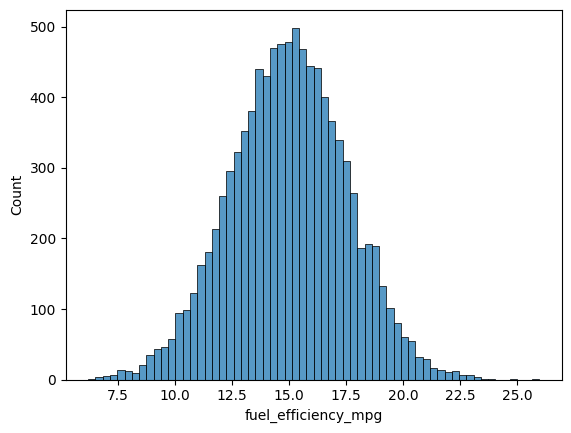

In [7]:
sns.histplot(df.fuel_efficiency_mpg)

### Question 1
There's one column with missing values. What is it? horsepower

In [8]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

### Question 2
What's the median (50% percentile) for variable 'horsepower'? 149

In [9]:
df.horsepower.median()

np.float64(149.0)

<Axes: xlabel='horsepower', ylabel='Count'>

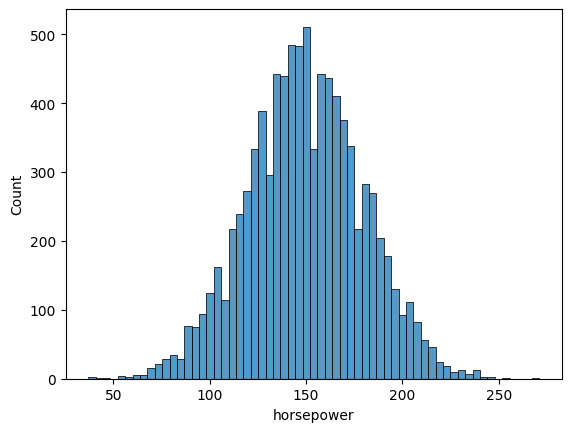

In [10]:
sns.histplot(df.horsepower)

#### Prepare and split the dataset
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution

In [11]:
n= len(df)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train= n-(n_val+n_test)

#### Shuffling the df

In [29]:
# make it prduicible by fixing the seed to 42(seed(42))
np.random.seed(42)
idx= np.arange(n)
np.random.shuffle(idx)

In [30]:
# validation df 
df_val= df.iloc[idx[:n_val]].reset_index(drop=True)
df_val.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,220,144.0,2535.887591,2009,16.642943
1,160,141.0,2741.170484,2019,16.298377
2,230,155.0,2471.880237,2017,18.591822
3,150,206.0,3748.164469,2015,11.818843
4,300,111.0,2135.716359,2006,19.402209


In [31]:
# test df 
df_test= df.iloc[idx[n_val:n_test+n_val]].reset_index(drop=True)
df_test.head()


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,110,144.0,2915.183706,2013,15.346002
1,200,105.0,2850.760653,2008,16.294345
2,180,125.0,3824.871931,2010,10.643505
3,260,160.0,2651.797255,2018,16.908809
4,210,131.0,3003.607759,2018,14.551272


In [32]:
# train df 
df_train= df.iloc[idx[n_test+n_val:]].reset_index(drop=True)

print(len(df_train)/len(df)*100)
df_train.head()

60.01648804616653


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,70,87.0,3346.134219,2004,13.085351
1,280,147.0,4193.817815,2017,9.385060
2,240,137.0,2471.172629,2010,17.697460
3,240,127.0,4044.606636,2000,9.298735
4,280,NaN,3039.297482,2011,14.724394


In [33]:
def df_model_frame(df):
    n= len(df)
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train= n-(n_val+n_test)
    
    # make it prduicible by fixing the seed to 42(seed(42))
    np.random.seed(42)
    idx= np.arange(n)
    np.random.shuffle(idx)
    df_val= df.iloc[idx[:n_val]].reset_index(drop=True)
    df_test= df.iloc[idx[n_val:n_test+n_val]].reset_index(drop=True)
    df_train= df.iloc[idx[n_test+n_val:]].reset_index(drop=True)
    return df_val,df_test, df_train

### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [34]:
# linear regression model 
def train_lr(X,Y):
    ones= np.ones(X.shape[0])
    X=np.column_stack([ones,X])
    XTX= X.T.dot(X)
    XTX_inv= np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(Y)
    return w_full[0], w_full[1:]


# RMSE
def rmse(y,y_pred):
    error= y-y_pred
    se=error**2
    mse=se.mean()
    return np.sqrt(mse)

In [35]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [36]:
# filling na with 0
df_zero_train= df_train.copy() # training df 
df_zero_val= df_val.copy() # validation df 

df_zero_train['horsepower'] = df_zero_train['horsepower'].fillna(0)
df_zero_val['horsepower']   = df_zero_val['horsepower'].fillna(0)

df_zero_train.isna().sum()

base= ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_zero_train= df_zero_train[base].values
Y_zero_train= df_zero_train.fuel_efficiency_mpg.values

# train the model
W_zero_0,W_zero= train_lr(X_zero_train,Y_zero_train)

# predict on val data set 

X_zero_val= df_zero_val[base].values

y_zero_val= df_zero_val.fuel_efficiency_mpg.values
y_zero_pred= W_zero_0+X_zero_val.dot(W_zero)


# RMSE
rmse_zero= rmse(y_zero_val,y_zero_pred)
    


In [37]:
# filling na with the mean
df_mean_train= df_train.copy()
df_mean_val= df_val.copy()

mean_val=  df_train['horsepower'].mean()
df_mean_train['horsepower'] = df_mean_train['horsepower'].fillna(mean_val)
df_mean_val['horsepower']   = df_mean_val['horsepower'].fillna(mean_val)

base= ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_mean_train= df_mean_train[base].values
Y_mean_train= df_mean_train.fuel_efficiency_mpg.values

# train the model
W_mean_0,W_mean= train_lr(X_mean_train,Y_mean_train)

# predict on val data set 

X_mean_val= df_mean_val[base].values

y_mean_val= df_mean_val.fuel_efficiency_mpg.values
y_mean_pred= W_mean_0+X_mean_val.dot(W_mean)


# RMSE
rmse_mean= rmse(y_mean_val,y_mean_pred)
    
print(f"RMSE (fill with mean):", round(rmse_mean,2))
print(f"RMSE (fill with 0)", round(rmse_zero,2))

RMSE (fill with mean): 0.47
RMSE (fill with 0) 0.53


### Question 4

In [38]:

# linear regression regularized  model 
def train_lr_reg(X,Y,r):
    ones= np.ones(X.shape[0])
    X=np.column_stack([ones,X])
    XTX= X.T.dot(X)
    XTX= XTX + r*np.eye(XTX.shape[0])
    XTX_inv= np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(Y)
    return w_full[0], w_full[1:]


In [39]:
# train the model
r_val=[0, 0.01, 0.1, 1, 5, 10, 100]
for r in r_val:
    W_zero_0,W_zero = train_lr_reg(X_zero_train,Y_zero_train,r)

    # predict on val data set 

    X_zero_val= df_zero_val[base].values

    y_zero_val= df_zero_val.fuel_efficiency_mpg.values
    y_zero_pred= W_zero_0+X_zero_val.dot(W_zero)


    # RMSE
    rmse_zero= rmse(y_zero_val,y_zero_pred)
    
    print(f'The rmse corresponding to r= {r} is  :',round(rmse_zero,2))

The rmse corresponding to r= 0 is  : 0.53
The rmse corresponding to r= 0.01 is  : 0.53
The rmse corresponding to r= 0.1 is  : 0.53
The rmse corresponding to r= 1 is  : 0.54
The rmse corresponding to r= 5 is  : 0.54
The rmse corresponding to r= 10 is  : 0.54
The rmse corresponding to r= 100 is  : 0.54


### Question 5

In [40]:
def df_model_frame(df,s):
    n = len(df)
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train = n-(n_val+n_test)
    
    # make it prduicible by fixing the seed to 42(seed(42))
    np.random.seed(s)
    idx= np.arange(n)
    np.random.shuffle(idx)
    df_val= df.iloc[idx[:n_val]].reset_index(drop=True)
    df_test= df.iloc[idx[n_val:n_test+n_val]].reset_index(drop=True)
    df_train= df.iloc[idx[n_test+n_val:]].reset_index(drop=True)
    return df_val,df_test, df_train

In [ ]:

seed_val= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_clct=[]
for s in seed_val:
    df_val,df_test, df_train= df_model_frame(df,s)
    
    # filling na with 0
    df_zero_train= df_train.copy() # training df 
    df_zero_val= df_val.copy() # validation df 

    df_zero_train['horsepower'] = df_zero_train['horsepower'].fillna(0)
    df_zero_val['horsepower']   = df_zero_val['horsepower'].fillna(0)

    df_zero_train.isna().sum()

    base= ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
    X_zero_train= df_zero_train[base].values
    Y_zero_train= df_zero_train.fuel_efficiency_mpg.values

    # train the model
    W_zero_0,W_zero= train_lr(X_zero_train,Y_zero_train)

    # predict on val data set 

    X_zero_val= df_zero_val[base].values

    y_zero_val= df_zero_val.fuel_efficiency_mpg.values
    y_zero_pred= W_zero_0+X_zero_val.dot(W_zero)


    # RMSE
    rmse_zero= rmse(y_zero_val,y_zero_pred)
    rmse_clct.append(rmse_zero)
    print(f'The rmse corresponding to s= {s} is  :',round(rmse_zero,2))

The rmse corresponding to s= 0 is  : 0.52
The rmse corresponding to s= 1 is  : 0.51
The rmse corresponding to s= 2 is  : 0.52
The rmse corresponding to s= 3 is  : 0.51
The rmse corresponding to s= 4 is  : 0.51
The rmse corresponding to s= 5 is  : 0.5
The rmse corresponding to s= 6 is  : 0.51
The rmse corresponding to s= 7 is  : 0.52
The rmse corresponding to s= 8 is  : 0.53
The rmse corresponding to s= 9 is  : 0.52


In [ ]:
# score std
round(np.std(rmse_clct),3)


np.float64(0.008)

### Question 6

In [49]:
df_val,df_test, df_train= df_model_frame(df,s=9)
df_full = pd.concat([df_train, df_val], ignore_index=True)   
# filling na with 0
df_zero_train= df_full.copy() # training df 
df_zero_test= df_val.copy() # validation df 

df_zero_train['horsepower'] = df_zero_train['horsepower'].fillna(0)
df_zero_test['horsepower']   = df_zero_test['horsepower'].fillna(0)

df_zero_train.isna().sum()

base= ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
X_zero_train= df_zero_train[base].values
Y_zero_train= df_zero_train.fuel_efficiency_mpg.values

# train the model
W_zero_0,W_zero= train_lr_reg(X_zero_train,Y_zero_train,r=0.001)

# predict on val data set 

X_zero_test= df_zero_test[base].values

y_zero_test= df_zero_test.fuel_efficiency_mpg.values
y_zero_pred= W_zero_0+X_zero_test.dot(W_zero)


# RMSE
rmse_zero= rmse(y_zero_test,y_zero_pred)
round(rmse_zero,2)

np.float64(0.52)